In [1]:
import numpy as np
import cv2
import time
from matplotlib import pyplot as plt

Implementemos una versión "ingenua" de los mapas de probabilidad de color.

Esta implementación se basea en el artículo original: [Statistical Color Models with Applications on Skin Detection](https://www.hpl.hp.com/techreports/Compaq-DEC/CRL-98-11.pdf).

Los datos fueron tomados de [UCI Skin Detection Data Set](https://archive.ics.uci.edu/ml/datasets/skin+segmentation)

In [2]:
## Cargue valores de pixeles con su clase (R,G,B,clase)
data = np.loadtxt('Skin_NonSkin.txt')

## Separemos los datos en 
skin = data[data[:,3]==1,0:3]
non_skin = data[data[:,3]==2,0:3]

print("Datos piel: ",skin.shape)
print("Datos no piel: ",non_skin.shape)

Datos piel:  (50859, 3)
Datos no piel:  (194198, 3)


In [3]:
def compute_histo(data,bins=32):
    ## Asumimos que los datos van entre 0 y 255
    f=256/bins
    idx=(data/f).astype(int)
    histo,_=np.histogramdd(data,bins=(bins,bins,bins),density=True)
    return histo
    

In [4]:
hskin=compute_histo(skin)
hnon_skin=compute_histo(non_skin)

# Implementación ingenua

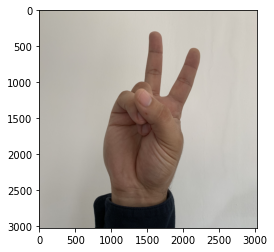

In [5]:
img = cv2.imread('gesture_accept.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [6]:
rows, cols, _ = img.shape
bins = hskin.shape[0];
f=256/bins;
eps=1e-10; ## Para evitar divisiones por cero
spm = np.zeros((rows,cols))


priori=skin.shape[0]/(skin.shape[0]+non_skin.shape[0])
#priori=0.5

# Esto es bastante lento.  Con esta variable puede saltarse la versión lenta
do_slow_version=False
if do_slow_version: 
    tik=time.time_ns()
    for row in range(0,rows):
        for col in range(0,cols):
            colorIdx = (img[row,col,:]/f).astype(int)               
            P_rgb_skin = hskin[tuple(colorIdx)]+eps
            P_rgb_non_skin = hnon_skin[tuple(colorIdx)]+eps    

            spm[row,col] = (P_rgb_skin*priori)/(P_rgb_skin*priori + P_rgb_non_skin*(1-priori))
    tok=time.time_ns()

In [ ]:
print("Tiempo versión ingenua: {0}s".format((tok-tik)/10**9))

In [ ]:
plt.figure()
plt.imshow(spm, cmap='gray')
print("Máxima probabilidad encontrada=",np.max(spm))

# Tarea: vectoricemos el cálculo

In [7]:
def probmap(img,priori=0.5):
    rows, cols, _ = img.shape
    bins = hskin.shape[0];
    f=256/bins;
    eps=1e-10; ## Para evitar divisiones por cero
    
    idx=(img.reshape(-1,3)/f).astype(int)
    tidx=tuple(idx.T)
    
    P_rgb_skin = hskin[tidx] + eps
    P_rgb_non_skin = hnon_skin[tidx] + eps
    P = (P_rgb_skin*priori)/(P_rgb_skin*priori + P_rgb_non_skin*(1-priori))
    
    spm = P.reshape(rows,cols)
    
    return spm

Tiempo versión vectorizada: 397.965358ms


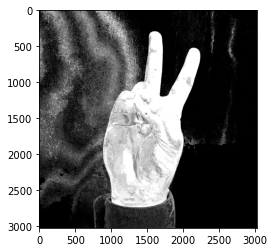

In [8]:
tik=time.time_ns()
spm=probmap(img)
tok=time.time_ns()

print("Tiempo versión vectorizada: {0}ms".format((tok-tik)/10**6))

plt.figure()
_=plt.imshow(spm, cmap='gray')

# Tarea: usemos vectorización para verlo con la cámara

In [ ]:
cam = cv2.VideoCapture(0)
cam.set(cv2.CAP_PROP_FRAME_WIDTH, 320)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 240)

priori=0.5

while True:
    ret, img = cam.read()
    rows, cols, _ = img.shape
    
    pmap=probmap(img,priori)
    
    cv2.imshow('Probability Map', pmap)
    cv2.imshow('Original', img)
    
    if (cv2.waitKey(1) & 0xFF) == ord('q'):
        break

In [ ]:
cam.release()
cv2.destroyAllWindows()